# Complex Data Analysis Project
### Group 7
* Tommaso Tragno - fc64699
* Antonio Alampi - fc64316
* Meike Veen - fc64408

In [11]:
# netowrks
import networkx as nx
import igraph as ig

# data processing
import pandas as pd
import numpy as np

#some functions to make our lifes easier
import sys
sys.path.append("../")
from common_functions import *

# viz
#import pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns

# gzip
import gzip
import statistics

from scipy.sparse import diags, csr_matrix

### Graph creation

In [2]:
# Path to file
file_path = 'soc-Epinions1.txt.gz'

# Initialize a directed graph
G = nx.DiGraph()

# Load the edge list into the directed graph
with gzip.open(file_path, 'rt') as f:
    # Skip header lines that start with '#'
    edges = [line.strip().split('\t') for line in f if not line.startswith('#')]
    # Add edges to the graph
    G.add_edges_from((int(src), int(dst)) for src, dst in edges)



## Dataset Statistics

In [4]:
is_directed = G.is_directed()
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Extract the largest Weakly Connected Component (WCC)
# For a directed graph, weakly connected components treat edges as undirected for connectivity purposes
largest_wcc = max(nx.weakly_connected_components(G), key=len)

# Create a subgraph of the largest WCC
G_wcc = G.subgraph(largest_wcc).copy()

# Statistics for the largest WCC
wcc_num_nodes = G_wcc.number_of_nodes()
wcc_num_edges = G_wcc.number_of_edges()

# Extract the largest Strongly Connected Component (SCC)
# For a directed graph, strongly connected components treat edges as undirected for connectivity purposes
largest_scc = max(nx.strongly_connected_components(G), key=len)

# Create a subgraph of the largest WCC
G_scc = G.subgraph(largest_scc).copy()

# Statistics for the largest WCC
scc_num_nodes = G_scc.number_of_nodes()
scc_num_edges = G_scc.number_of_edges()

avg_clustering_coeff = nx.average_clustering(G)
num_triangles = 0# nx.triangles(G)
diameter = 0#nx.diameter(G)

# Print statistics
print("Is Directed:", is_directed)
print("Total Nodes:", num_nodes)
print("Total Edges:", num_edges)
print("Nodes in largest WCC:", wcc_num_nodes)
print("Edges in largest WCC:", wcc_num_edges)
print("Nodes in largest SCC:", scc_num_nodes)
print("Edges in largest SCC:", scc_num_edges)
print("Average clustering coefficient:", avg_clustering_coeff)
print("Number of triangles:", num_triangles)
print("Diameter (longest shortest path):", diameter)

Is Directed: True
Total Nodes: 75879
Total Edges: 508837
Nodes in largest WCC: 75877
Edges in largest WCC: 508836
Nodes in largest SCC: 32223
Edges in largest SCC: 443506
Average clustering coefficient: 0.11017387558244757
Number of triangles: 0
Diameter (longest shortest path): 0


### Degree analysis

In [5]:
def degreeAnalisys(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(12, 12))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(6, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title("Weakly connected components of G")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:4, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:4, 2:])
    unique_degrees, counts = np.unique(degree_sequence, return_counts=True)
    ax2.bar(unique_degrees, counts, width=0.80, color="b")
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    # Log-log plot
    ax3 = fig.add_subplot(axgrid[4:, :])
    ax3.scatter(unique_degrees, counts, color="b", alpha=0.6, edgecolors="k")
    ax3.set_xscale("log")
    ax3.set_yscale("log")
    ax3.set_title("Degree Distribution (Log-Log)")
    ax3.set_xlabel("Degree (log scale)")
    ax3.set_ylabel("Frequency (log scale)")

    fig.tight_layout()
    plt.show()

In [ ]:
degreeAnalisys(G)

In [95]:
degrees = [G.degree(n) for n in G.nodes]
print('Mean degree:', statistics.mean(degrees))
print('Median degree:', statistics.median(degrees))

Mean degree: 13.411800366372777
Median degree: 2


In [96]:
def compute_degree(graph):
    # Compute in-degree and out-degree for each node
    degree_data = {
        "Node": [],
        "In-Degree": [],
        "Out-Degree": []
    }

    for node in graph.nodes:
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        degree_data["Node"].append(node)
        degree_data["In-Degree"].append(in_degree)
        degree_data["Out-Degree"].append(out_degree)
    
    return degree_data

In [97]:
degree_data = compute_degree(G)

In [98]:
# Calculate the average in-degree and out-degree
total_in_degree = sum(degree_data["In-Degree"])
total_out_degree = sum(degree_data["Out-Degree"])
num_nodes = G.number_of_nodes()

average_in_degree = total_in_degree / num_nodes
average_out_degree = total_out_degree / num_nodes

# Display the average degree
print(f"Average in-degree: {average_in_degree}")
print(f"Average out-degree: {average_out_degree}")

Average in-degree: 6.7059001831863885
Average out-degree: 6.7059001831863885


In [99]:
# Convert results to a pandas DataFrame for easier analysis and viewing
degree_df = pd.DataFrame(degree_data)
degree_df.head()  # Display the first few rows

# Save the DataFrame to a CSV file
degree_df.to_csv('node_degrees.csv', index=False)

### Hub finding:
* most trusted nodes
* more truster nodes
* both trusted and truster

In [101]:
node_data = list(zip(degree_data["Node"], degree_data["In-Degree"], degree_data["Out-Degree"]))

# Sort by In-Degree in descending order and take the top 5
top_in_degree = sorted(node_data, key=lambda x: x[1], reverse=True)[:5]

# Sort by Out-Degree in descending order and take the top 5
top_out_degree = sorted(node_data, key=lambda x: x[2], reverse=True)[:5]

# Display results
print("Top 5 nodes by In-Degree:", top_in_degree)
print("Top 5 nodes by Out-Degree:", top_out_degree)

threshold = 600
top_in_out_degree = []
for i in range(len(degree_data["Node"])):
    in_degree = degree_data["In-Degree"][i]
    out_degree = degree_data["Out-Degree"][i]
    if in_degree > threshold and out_degree > threshold:
        top_in_out_degree.append(degree_data["Node"][i])

# Output the result
print(f'There are {len(top_in_out_degree)} nodes with both In-Degree and Out-Degree above the threshold: {top_in_out_degree}')
print(f'The in degree is {G.in_degree(top_in_out_degree)} and the out degree is {G.out_degree(top_in_out_degree)}')

Top 5 nodes by In-Degree: [(18, 3035, 44), (143, 1521, 171), (737, 1317, 372), (790, 1284, 102), (136, 1180, 111)]
Top 5 nodes by Out-Degree: [(645, 408, 1801), (763, 293, 1669), (634, 378, 1621), (71399, 116, 1128), (3924, 92, 976)]
There are 1 nodes with both In-Degree and Out-Degree above the threshold: [44]
The in degree is [(44, 672)] and the out degree is [(44, 843)]


### Hub analysis

In [161]:
# Define the two hub nodes
node_a = 18
node_b = 143

# Check if the hubs are connected
if G.has_edge(node_a, node_b):
    print(f'The hubs {node_a} and {node_b} are directly connected.')
else:
    print(f'The hubs {node_a} and {node_b} are not directly connected.')
    
    # If not directly connected, find the shortest path (if it exists)
    try:
        path = nx.shortest_path(G, node_a, node_b)
        print(f'The shortest path between {node_a} and {node_b} is: {path}')
    except nx.NetworkXNoPath:
        print(f'There is no path between {node_a} and {node_b}.')

# Get the predecessors of the target nodes
predecessors_a = set(G.predecessors(node_a))
predecessors_b = set(G.predecessors(node_b))

# Find nodes that have outgoing edges to both target nodes
common_predecessors = predecessors_a & predecessors_b

# Output the result
print(f'There are {len(common_predecessors)} nodes with outgoing edges to both {node_a} and {node_b}: {common_predecessors}')

The hubs 18 and 143 are not directly connected.
The shortest path between 18 and 143 is: [18, 128, 143]
There are 588 nodes with outgoing edges to both 18 and 143: {4100, 2055, 2057, 4110, 6159, 16, 10259, 2069, 27, 31, 16416, 33, 36, 2084, 39, 2088, 2097, 2103, 58, 62, 65, 67, 4165, 4167, 6215, 77, 79, 82, 83, 85, 4182, 10330, 91, 4187, 4188, 8288, 2144, 10338, 99, 12388, 4197, 14438, 4199, 2152, 4200, 4202, 107, 2157, 112, 18544, 119, 2167, 71801, 8316, 124, 126, 128, 8321, 10378, 140, 141, 2189, 6285, 145, 146, 8344, 2201, 172, 10413, 2226, 37043, 2231, 2232, 18620, 198, 4295, 12496, 212, 215, 217, 4313, 2270, 223, 225, 2277, 6374, 8423, 232, 2279, 30953, 6378, 4333, 4334, 239, 2287, 6382, 8434, 6383, 6393, 6397, 6402, 2308, 14600, 4368, 6419, 2329, 290, 291, 4394, 8491, 24877, 8495, 4406, 318, 320, 2369, 4418, 329, 340, 342, 343, 6487, 348, 8541, 356, 2410, 375, 379, 45439, 384, 385, 57728, 2433, 4482, 6527, 8592, 6555, 418, 8613, 2470, 2471, 431, 4527, 4537, 443, 445, 447, 14783, 

In [ ]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
print("Top 20 nodes by degree centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20])

# Betweenness centrality (for larger graphs, consider approximations)
betweenness_centrality = nx.betweenness_centrality(G)
print("Top 20 nodes by betweenness centrality:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:20])

Top 5 nodes by degree centrality: [(18, 0.04057829673950289), (645, 0.029112522733862254), (634, 0.026344922111811067), (763, 0.02585729724030681), (143, 0.022298953583383855)]


KeyboardInterrupt: 

## Core network

In [3]:
def get_core_nodes(graph, threshold):
    """
    Recursively removes nodes with in-degree + out-degree < threshold and returns the core graph.
    
    Parameters:
    - graph: A NetworkX DiGraph (directed graph)
    
    Returns:
    - A NetworkX DiGraph representing the core of the network
    """
    # Create a copy of the graph to avoid modifying the original
    core_graph = graph.copy()
    
    count = 0
    number_of_removed = 0
    while True:
        # Identify nodes with in-degree + out-degree < threshold
        nodes_to_remove = [
            node for node in core_graph.nodes 
            if core_graph.in_degree(node) + core_graph.out_degree(node) < threshold
        ]
        
        # Exit condition - if no nodes meet the condition, stop the process
        if not nodes_to_remove:
            break
        
        # Remove the identified nodes
        core_graph.remove_nodes_from(nodes_to_remove)
        number_of_removed += len(nodes_to_remove)
        print(f'Iteration {count}: removed {len(nodes_to_remove)} nodes')
        count += 1
    print(f'Executed {count} iterations, removed {number_of_removed} nodes')
    return core_graph

In [4]:
# Get the core graph
threshold = 4
core_G = get_core_nodes(G, threshold)
# Print the number of nodes and edges in the original and core graphs
print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Core Graph: {core_G.number_of_nodes()} nodes, {core_G.number_of_edges()} edges")

Iteration 0: removed 49243 nodes
Iteration 1: removed 2772 nodes
Iteration 2: removed 309 nodes
Iteration 3: removed 44 nodes
Iteration 4: removed 8 nodes
Executed 5 iterations, removed 52376 nodes
Original Graph: 75879 nodes, 508837 edges
Core Graph: 23503 nodes, 431564 edges


The core graph has the 30,87% of node of the original graph.

In [165]:
core_degree_data = compute_degree(core_G)

core_node_data = list(zip(core_degree_data["Node"], core_degree_data["In-Degree"], core_degree_data["Out-Degree"]))

# Sort by In-Degree in descending order and take the top 5
core_top_in_degree = sorted(core_node_data, key=lambda x: x[1], reverse=True)[:5]

# Sort by Out-Degree in descending order and take the top 5
core_top_out_degree = sorted(core_node_data, key=lambda x: x[2], reverse=True)[:5]

# Display results
print("Top 5 nodes by In-Degree:", core_top_in_degree)
print("Top 5 nodes by Out-Degree:", core_top_out_degree)

Top 5 nodes by In-Degree: [(18, 2761, 44), (143, 1438, 143), (737, 1199, 370), (790, 1193, 102), (1179, 1119, 85)]
Top 5 nodes by Out-Degree: [(645, 390, 1632), (634, 351, 1350), (763, 251, 1053), (71399, 109, 932), (3924, 92, 901)]


## Random network

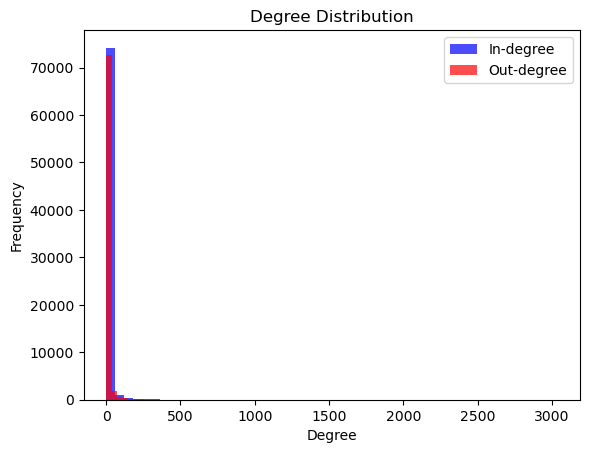

In [166]:
# Compute in-degree and out-degree distributions
in_degrees = [G_wcc.in_degree(n) for n in G_wcc.nodes()]
out_degrees = [G_wcc.out_degree(n) for n in G_wcc.nodes()]

# Plot in-degree distribution
plt.hist(in_degrees, bins=50, color='blue', alpha=0.7, label='In-degree')
plt.hist(out_degrees, bins=50, color='red', alpha=0.7, label='Out-degree')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("Degree Distribution")
plt.show()

In [ ]:
# Calculate the average clustering coefficient
avg_clustering = nx.average_clustering(G_wcc.to_undirected())  # Convert to undirected for clustering
print("Average Clustering Coefficient:", avg_clustering)

In [ ]:
# Calculate the average shortest path length
# This can be computationally intensive; only use on smaller graphs or expect it to take time
try:
    avg_shortest_path_length = nx.average_shortest_path_length(G_wcc)
    print("Average Shortest Path Length:", avg_shortest_path_length)
except Exception as e:
    print("Error calculating shortest path length:", e)

Error calculating shortest path length: Graph is not strongly connected.


In [105]:
# Calculate assortativity coefficient
assortativity = nx.degree_assortativity_coefficient(G_wcc)
print("Assortativity Coefficient:", assortativity)

Assortativity Coefficient: -0.04128687053958363


In [ ]:
nx.draw_networkx(G, node_size=1000, node_color='lightblue', with_labels=True, font_size=8)

## Partitions

It will be created random partitions (3 and 9) of both the full graph and the core graph.

In [168]:
# 3 partitions from original graph (75879 nodes)
random_nodes = random.sample(list(G.nodes), 25293)
random_partition = [set(random_nodes), set(G.nodes) - set(random_nodes)]
if nx.community.is_partition(G, random_partition) == True:
    print("3 random partition of the full graph were obtained, each one with 25293 nodes.")


# 9 partition from original graph
random_nodes_2 = random.sample(list(G.nodes), 8431)
random_partition_2 = [set(random_nodes_2), set(G.nodes) - set(random_nodes_2)]
if nx.community.is_partition(G, random_partition_2) == True:
    print("9 random partition of the full graph were obtained, each one with 8431.")


# 3 partitions from core graph (23503 nodes)
random_nodes_3 = random.sample(list(core_G.nodes), 7834)
random_partition_3 = [set(random_nodes_3), set(core_G.nodes) - set(random_nodes_3)]
if nx.community.is_partition(core_G, random_partition_3) == True:
    print("3 random partition of the core graph were obtained, around 7834 nodes in each partitions.")

# 9 partition from core graph
random_nodes_4 = random.sample(list(core_G.nodes), 2611)
random_partition_4 = [set(random_nodes_4), set(core_G.nodes) - set(random_nodes_4)]
if nx.community.is_partition(core_G, random_partition_4) == True:
    print("9 random partition of the core graph were obtained, around 2611 nodes in each partitions.")

# 27 partition from core graph
random_nodes_5 = random.sample(list(core_G.nodes), 870)
random_partition_5 = [set(random_nodes_5), set(core_G.nodes) - set(random_nodes_5)]
if nx.community.is_partition(core_G, random_partition_5) == True:
    print("27 random partition of the core graph were obtained, around 870 nodes in each partitions.")

3 random partition of the full graph were obtained, each one with 25293 nodes.
9 random partition of the full graph were obtained, each one with 8431.
3 random partition of the core graph were obtained, around 7834 nodes in each partitions.
9 random partition of the core graph were obtained, around 2611 nodes in each partitions.
27 random partition of the core graph were obtained, around 870 nodes in each partitions.


In [169]:
#This function verify if the nodes are in the same partitions:

def make_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map


pmap = make_partition_map(random_partition)
pmap2 = make_partition_map(random_partition_2)
pmap3 = make_partition_map(random_partition_3)
pmap4 = make_partition_map(random_partition_4)
pmap5 = make_partition_map(random_partition_5)

# Let's control for the interesting nodes: (well, there are random partitions, is not particularly interesting)
print(pmap[18] == pmap[143])
print(pmap2[18] == pmap2[143])
print(pmap3[18] == pmap3[143])
print(pmap4[18] == pmap4[143])
print(pmap5[18] == pmap5[143])

False
True
False
True
True


## Modularity

The modularity of a graph partition compares the number of intra-group edges with a random baseline. Higher modularity scores correspond to a **higher proportion of intra-group edges**, therefore **fewer inter-group edges** and better separation of groups.

$$ Q_w=\frac{1}{W}\sum_C \left(W_C-\frac{s_C^2}{4W}\right) $$
    
where 
* $W$ is the total weight of the links of the network,
* $W_C$ the total weight of the internal links of cluster $C$, and
* $s_C$ the total strength of the nodes of $C$.


In [170]:
# Modularity of first partition of the full graph
print("Modularity %7.4f" % nx.community.quality.modularity(G, random_partition))

# Modularity of second partition of the full graph
print("Modularity %7.4f" % nx.community.quality.modularity(G, random_partition_2))

# Modularity of first partition of the core graph
print("Modularity %7.4f" % nx.community.quality.modularity(core_G, random_partition_3))
      
# Modularity of second partition of the core graph
print("Modularity %7.4f" % nx.community.quality.modularity(core_G, random_partition_4))

# Modularity of third partition of the core graph
print("Modularity %7.4f" % nx.community.quality.modularity(core_G, random_partition_5))

Modularity -0.0003
Modularity -0.0000
Modularity  0.0002
Modularity -0.0003
Modularity  0.0001


Since this is a random process the modularity won't be exactly zero, but it should be fairly close.

### Create the Adjacencies and the Laplacian of a Graph

Now it will be created the adjaceny and laplacian matrix from the set of nodes.

In [ ]:
def compute_graph_matrices(core_graph):
    """
    Computes the adjacency, degree, and Laplacian matrices for a core graph.

    Parameters:
    - core_graph: A NetworkX DiGraph (the core graph)

    Returns:
    - adjacency_matrix: A NumPy array (core_graph size x core_graph size)
    - degree_matrix: A sparse diagonal matrix (scipy.sparse)
    - laplacian_matrix: A sparse Laplacian matrix (scipy.sparse)
    - core_nodes: A list of node labels in the order they appear in the matrix
    """
    # Get the nodes of the core graph sorted by their original labels
    core_nodes = sorted(core_graph.nodes)
    node_mapping = {node: idx for idx, node in enumerate(core_nodes)}
    
    # Initialize adjacency matrix of size (core_graph size x core_graph size)
    size = len(core_nodes)
    adjacency_matrix = np.zeros((size, size))
    
    # Populate the adjacency matrix
    for u, v in core_graph.edges:
        adjacency_matrix[node_mapping[u], node_mapping[v]] = 1  # Directed edge from u to v

    # Compute the degree for each node (sum of rows in the adjacency matrix)
    degrees = np.sum(adjacency_matrix, axis=1)
    
    # Create the degree matrix as a sparse diagonal matrix
    degree_matrix = diags(degrees, offsets=0, format="csr")
    
    # Compute the Laplacian matrix
    laplacian_matrix = degree_matrix - csr_matrix(adjacency_matrix)

    return adjacency_matrix, degree_matrix, laplacian_matrix, core_nodes

(23503, 23503)


In [ ]:
adjacency_matrix, degree_matrix, laplacian_matrix, core_nodes = compute_graph_matrices(core_G)
print(laplacian_matrix)

In [ ]:
print(laplacian_matrix[(0,0)])

IndexError: row index (75000) out of range

And now eigenvalues and eigenvectors of Laplacian matrix

In [180]:
from scipy.sparse.linalg import eigsh

# Eigenvalues and eigenvectors from laplacian matrix
def compute_eigen(L_sparse, k=6):
    """
    Calcola i primi k autovalori e autovettori della matrice Laplaciana sparsa.
    """
    evals, evecs = eigsh(L_sparse, k=k, which='SM')  # 'SM' = smallest magnitude
    return evals, evecs

# First 6 eigenvalues and eigenvectors
evals, evecs = compute_eigen(L_sparse, k=6)

print("Autovalori:")
print(np.around(evals, 3))

print("\nAutovettori:")
for i in range(evecs.shape[1]):  # Iterations on eigenvectors
    print(np.around(evecs[:, i], 3))



KeyboardInterrupt: 

In [ ]:
eord = np.argsort(evals)
print(eord)

L1=evecs[:,eord[0]]
L2=evecs[:,eord[1]]
plt.plot(Nodes, L1, ".--", label="Eigen 1")
plt.plot(Nodes, L2, ".--", label="Eigen 2")
plt.ylim(-1,1)
plt.grid()
plt.legend()
plt.show()

In [ ]:
def GraphEdgeSplitter(Nodes, edges, L2, threshold=0.0):
    
    nodes_cluster_1=set(Nodes[L2>=threshold])
    nodes_cluster_2=set(Nodes[L2< threshold])

    inner_edges_1=[]
    inner_edges_2=[]
    between_edges=[]
    for i, j in edges:
        if   i in nodes_cluster_1 and j in nodes_cluster_1: inner_edges_1.append((i,j))
        elif i in nodes_cluster_2 and j in nodes_cluster_2: inner_edges_2.append((i,j))
        else: between_edges.append((i,j))
    return inner_edges_1, inner_edges_2, between_edges
        
def plotClusteredGraph(edges_1, edges_2, edges_b):

    G = pgv.AGraph(strict=False, directed=False)
    G.engine="fdp"
    sg1 = G.subgraph(name='cluster_0', label='Cluster 1', color='blue')
    for i,j in edges_1: sg1.add_edge(str(i), str(j))

    sg2 = G.subgraph(name='cluster_1', label='Cluster 2', color='red')
    for i,j in edges_2: sg2.add_edge(str(i), str(j))

    for i,j in edges_b: G.add_edge(str(i), str(j))
    return G

e1, e2, eb = GraphEdgeSplitter(Nodes, edges, L2) # we can modify the treshold
G=plotClusteredGraph(e1, e2, eb)
G.layout(prog='dot')
G.draw('fig_2.png')
img = mpimg.imread('fig_2.png')
plt.figure(figsize=(5,10))
plt.imshow(img)
plt.show()